Introduction:
    My sub metric is walkability which I am defining by sidewalk to street ratio. The best neighborhood by this metric will be the neighborhood with the highest average sidewalk to street ratio.

Dataset: https://data.wprdc.org/dataset/sidewalk-to-street-walkability-ratio

In [2]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
csv_path = "StreetBlockgroupWithExclusions.csv"
df = pd.read_csv(csv_path, dtype='object')

lat_col = "INTPTLAT"
lon_col = "INTPTLON"

df[lat_col] = pd.to_numeric(df[lat_col], errors="coerce")
df[lon_col] = pd.to_numeric(df[lon_col], errors="coerce")

df = df.dropna(subset=[lat_col, lon_col])

geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
gdf_points = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

shapefile_zip = "City_of_Pittsburgh_Neighborhoods.zip" 
neigh_gdf = gpd.read_file(shapefile_zip)

if neigh_gdf.crs is None:
    raise ValueError("Neighborhood shapefile has no CRS defined.")

gdf_points = gdf_points.to_crs(neigh_gdf.crs)

gdf_joined = gpd.sjoin(gdf_points, neigh_gdf, how="left", predicate="within")

gdf_joined = gdf_joined.rename(columns={"hood": "neighborhood"})

output_path = "StreetBlockgroup_with_neighborhoods.csv"
gdf_joined.drop(columns="geometry").to_csv(output_path, index=False)

output_path

'StreetBlockgroup_with_neighborhoods.csv'

In [8]:
street_path = "StreetBlockgroup_with_neighborhoods.csv"
ratio_path = "sidewalkstreetratioupload.csv"

street_df = pd.read_csv(street_path)
ratio_df = pd.read_csv(ratio_path)

street_df.columns = street_df.columns.str.strip()
ratio_df.columns = ratio_df.columns.str.strip()

if "GEOID" in ratio_df.columns and "GEO_ID" not in ratio_df.columns:
    ratio_df = ratio_df.rename(columns={"GEOID": "GEO_ID"})

if "GEOID" in street_df.columns and "GEO_ID" not in street_df.columns:
    street_df = street_df.rename(columns={"GEOID": "GEO_ID"})

merged = street_df.merge(
    ratio_df[["GEO_ID", "Ratio"]],
    on="GEO_ID",
    how="left"  
)

merged = merged.rename(columns={"Ratio": "ratio"})

output_path = "StreetBlockgroupWithExclusions_with_ratio.csv"
merged.to_csv(output_path, index=False)

print("Done. File saved to:", output_path)

/scratch/slurm-23783/ipykernel_3729660/866798556.py:4: DtypeWarning: Columns (18,19,32) have mixed types. Specify dtype option on import or set low_memory=False.
  street_df = pd.read_csv(street_path)


Done. File saved to: StreetBlockgroupWithExclusions_with_ratio.csv


/scratch/slurm-23936/ipykernel_1431246/4192483817.py:1: DtypeWarning: Columns (18,19,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("StreetBlockgroupWithExclusions_with_ratio.csv")


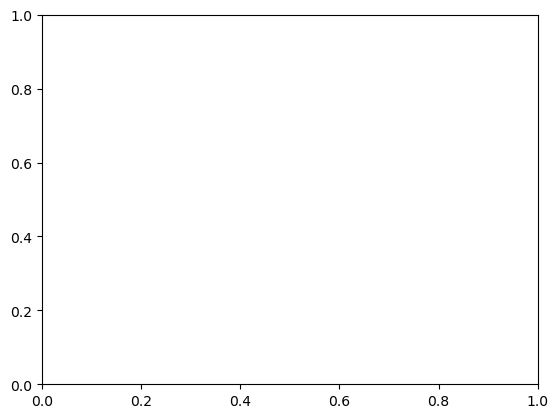

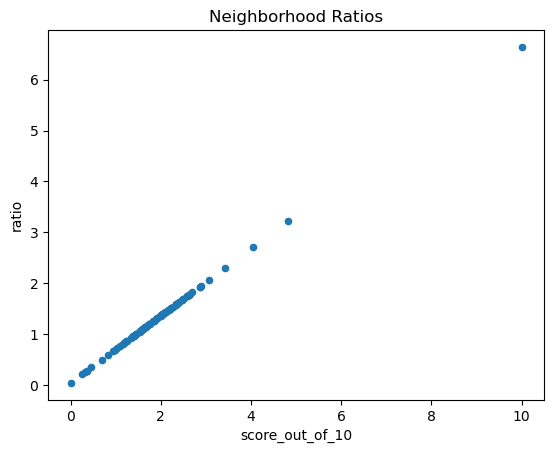

,HOOD,ratio,score_out_of_10
6,Bedford Dwellings,6.644908,10.000000
0,Allegheny Center,3.227465,4.820052
58,Northview Heights,2.712593,4.039641
56,North Oakland,2.300833,3.415521
83,Terrace Village,2.066504,3.060339
...,...,...,...
37,Hays,0.286175,0.361827
20,Chartiers City,0.284980,0.360016
81,Summer Hill,0.255189,0.314861
45,Lincoln Place,0.212775,0.250572


In [10]:
df = pd.read_csv("StreetBlockgroupWithExclusions_with_ratio.csv")
df_clean = df[df["HOOD"].notna()].copy()
avg_by_neighborhood = df_clean.groupby("HOOD")["ratio"].mean().reset_index().sort_values(by="ratio", ascending=False)
avg_by_neighborhood

ratio_min = avg_by_neighborhood["ratio"].min()
ratio_max = avg_by_neighborhood["ratio"].max()

avg_by_neighborhood["score_out_of_10"] = 10 * (avg_by_neighborhood["ratio"] - ratio_min) / (ratio_max - ratio_min)

avg_by_neighborhood.to_csv('avg_by_neighborhood', index=False)

avg_by_neighborhood.plot(kind='scatter', x='score_out_of_10', y='ratio', title="Neighborhood Ratios")
plt.show()
avg_by_neighborhood

I used this code to find the neighborhood by using a shapefile and another shapefile that I converted into a csv to create a new csv with a new column containing the neighborhoods. I then used a csv and that new csv to assign the ratios by comparing the geo_id values in the two csv's. I then created a sorted list in descending value of the average sidewalk to street ratio of each neighborhoods and removed the rows that didnt have an assigned value because the original dataset had some data that was outside of Pittsburgh.

The Best Neighborhood:
    By my metric the best neighborhood in Pittsburgh is Bedford Dwellings with a sidewalk to street ratio of about 6.6.